# Loop Hydrodynamics: Low-frequency (Lower energy)

In [1]:
import os
import sys
import subprocess
import multiprocessing

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces import EbtelInterface

sys.path.append('../../scripts/')
from constrained_heating_model import CustomHeatingModel

%matplotlib inline

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [13]:
heating_options = {
    'duration': 200.0,
    'duration_rise': 100.0,
    'duration_decay': 100.0,
    'stress_level': 0.3,
    'power_law_slope': -2.5,
    'frequency_parameter': 5.
}

In [14]:
heating_model = CustomHeatingModel(heating_options)

In [15]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [16]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency_lower_energy/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency_lower_energy/hydro_results/')

In [17]:
heating_model.constrain_distribution(field,tolerance=1e-2,
                                     total_ar_flux=1e7,
                                     #sigma_increase=0.5,
                                     sigma_decrease=1e-2,
                                     max_iterations=30,verbose=True)

Iteration 0 with error=95.44538597308409 and phi=0.010368562372481762
Iteration 1 with error=50.05381169030775 and phi=0.019587176096977767
Iteration 2 with error=26.71990626362099 and phi=0.03607515806474348
Iteration 3 with error=14.112877000520317 and phi=0.0661687380877626
Iteration 4 with error=11.366691437799432 and phi=0.08086237172081842
Iteration 5 with error=11.414167602002188 and phi=0.08055312543377596
Iteration 6 with error=11.197717464470557 and phi=0.08198255148250436
Iteration 7 with error=11.404666997753507 and phi=0.08061482022702428
Iteration 8 with error=11.384104739552132 and phi=0.0807486710610754
Iteration 9 with error=11.432763654103757 and phi=0.08043263974296849
Iteration 10 with error=11.32914035755004 and phi=0.08110865567262573
Iteration 11 with error=11.398290876877747 and phi=0.08065627834760312
Iteration 12 with error=11.12810493981205 and phi=0.08245311241638192
Iteration 13 with error=11.301560849133054 and phi=0.08129049738192162
Iteration 14 with err

KeyboardInterrupt: 

In [ ]:
field.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [ ]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency_lower_energy/loop_parameters.h5'
                           )

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.05)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(0,base_config['total_time'])
#axes[0].set_ylim(0,20)
#axes[1].set_ylim(0,20)
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

## Sandbox

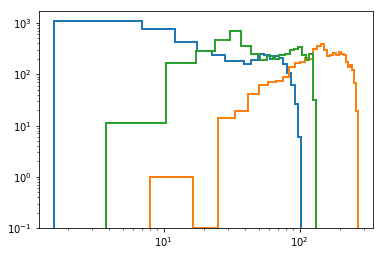

In [25]:
plt.hist(
    [l.field_strength.to(u.G).min().value for l in field.loops], histtype='step', lw=2, bins='fd',log=True,
);
plt.hist(
    [l.field_strength.to(u.G).max().value for l in field.loops], histtype='step', lw=2, bins='fd',log=True,
);
plt.hist(
    [l.field_strength.to(u.G).mean().value for l in field.loops], histtype='step', lw=2, bins='fd',log=True,
);
plt.xscale('log')